# Load the data

In [1]:
# Import necessary packages
using DrWatson
using JLD2

# Activate the project environment
@quickactivate :FlowComplexity

# Define the file path
file_path = joinpath("./data", "data.jld2")

# Load the data from the specified file
@load file_path sim_array

1-element Vector{Symbol}:
 :sim_array

# Show time series for all chemostats of simulation no. X

In [2]:
using DataFrames

sim_no = 90
sim = sim_array[sim_no]
nchem = 25

# Define the array that will hold our population time series
max_t = Int(sim.total_time)
nspecies = 10
pop_array = zeros(Int, nchem, max_t, nspecies)

# Populate the population array
time_series_df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
for i in 1:nchem
    for j in 1:max_t
        for k in 1:nspecies
            filtered_time_series_df = filter(row -> row[:reactor] == i && row[:time] == j && row[:variable] == string(k), time_series_df)
            if nrow(filtered_time_series_df) > 0
                pop_array[i, j, k] = filtered_time_series_df[1, :value]
            end
        end
    end
end

using Plots, FileIO

# Create a 3x3 grid plot
plot_grid = plot(layout = (5, 5))

# Loop over each subplot
for i in 1:nchem
    # Extract the time series data for the i-th plot
    time_series_data = pop_array[i, :, :]
    
    # Create a subplot for each species in the time series
    p = plot()
    for j in 1:nspecies
        plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none)
    end
end


display(plot_grid)

InterruptException: InterruptException:

In [2]:
sim_array[90].sim_number
sim_array[90].time_evolution[1][:complete_timeseries]

Dict{Any, Any} with 101 entries:
  5.0  => [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 2, 1, 1, 1, 1, 1, 1]
  56.0 => [1, 1, 3, 23, 1, 1, 1, 1, 1, 7  …  2, 1, 13, 1, 1, 1, 1, 36, 2, 1]
  35.0 => [12, 1, 4, 1, 1, 1, 5, 1, 1, 1  …  1, 4, 1, 1, 1, 3, 11, 3, 1, 1]
  55.0 => [15, 28, 1, 1, 1, 2, 20, 9, 1, 1  …  1, 1, 26, 1, 1, 1, 1, 124, 1, 3]
  60.0 => [2, 3, 1, 6, 1, 1, 1, 1, 3, 2  …  2, 1, 4, 1, 3, 1, 1, 1, 1, 1]
  30.0 => [2, 2, 1, 1, 1, 1, 1, 1, 1, 36  …  2, 1, 1, 1, 1, 5, 1, 2, 1, 1]
  32.0 => [1, 1, 1, 1, 6, 1, 1, 1, 1, 1  …  1, 2, 3, 2, 1, 1, 1, 1, 29, 1]
  6.0  => [1, 1, 1, 1, 1, 1, 2, 4, 1, 3  …  1, 1, 1, 1, 1, 1, 1, 2, 1, 1]
  67.0 => [19, 1, 1, 1, 1, 1, 1, 2, 1, 1  …  1, 9, 1, 1, 1, 1, 25, 1, 43, 93]
  45.0 => [14, 1, 1, 1, 62, 12, 1, 1, 1, 4  …  1, 1, 1, 19, 2, 1, 2, 71, 1, 2]
  73.0 => [1, 1, 1, 1, 1, 4, 1, 1, 1, 2  …  6, 1, 1, 2, 1, 1, 13, 1, 1, 17]
  64.0 => [1, 1, 1, 1, 61, 1, 1, 1, 1, 3  …  1, 3, 3, 3, 1, 1, 1, 71, 1, 1]
  90.0 => [1, 244, 1, 1, 92, 3, 23, 1, 6, 2  …  16, 1

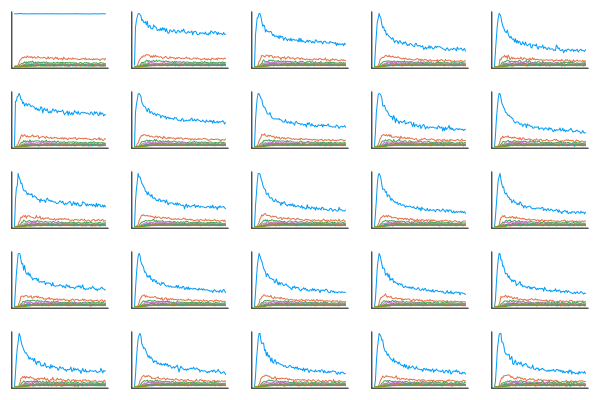

In [3]:
using DataFrames, Plots, FileIO

sim_no = 90
sim = sim_array[sim_no]
nchem = 25

# Define the array that will hold our population time series
max_t = Int(sim.total_time) + 1 # our sim goes to 0...100 so index has to go 1...101
nspecies = 10
pop_array = zeros(Int, nchem, max_t, nspecies)

# Convert the time series to a DataFrame
time_series_df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)

# Populate the population array using efficient DataFrame operations
for row in eachrow(time_series_df)
    
    i = Int(row[:reactor])
    j = round(Int, row[:time]) + 1 # indexing starts at 1
    k = parse(Int, row[:variable]) # to account for absent data (i.e., zero)
    if k > nspecies
        continue
    end
    # println(row)
    # println("i=$i j=$j k=$k")
    pop_array[i, j, k] = row[:value]
end

# Create a 3x3 grid plot
plot_grid = plot(layout = (5, 5))

# Loop over each subplot
for i in 1:nchem
    # Extract the time series data for the i-th plot
    time_series_data = pop_array[i, :, :]
    
    # Create a subplot for each species in the time series
    p = plot()
    for j in 1:nspecies
        # plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none)
        plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none, xlabel="", ylabel="", xticks=false, yticks=false)
    end
end

display(plot_grid)
# savefig(plot_grid, "./plots/ts-gridplot.pdf")

# Plot the Std(M) vs $k_d$ 

## (i.e., the std of monomers vs the outflow)

In [4]:
using DataFrames, Plots, FileIO, Statistics

first_sim = sim_array[1]
nsims = 100
nchem = 25
nspecies = 10
t = 100

# Define the array that will hold our data
pops = zeros(Float64, nsims, nchem, nspecies)

# Loop over all the simulations
for i in 1:100
    try
        sim = sim_array[i]
        df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
        df = filter(row -> row[:time] == t, df)

        for j in 1:nchem
            df_reactor = filter(row -> row[:reactor] == j, df)

            for k in 1:nspecies
                df_reactor_species = filter(row -> row[:variable] == string(k), df_reactor)
                if nrow(df_reactor_species) > 0
                    pops[i, j, k] = df_reactor_species[1, :value]      
                end
            end
        end
    catch
        continue
    end
end

In [3]:
using DataFrames, Plots, FileIO, Statistics, FlowComplexity
using Base.Threads: @threads

first_sim = sim_array[1]
nsims = 100
nchem = 9
nspecies = 10
t = 500

# Define the array that will hold our data
pops = zeros(Float64, nsims, nchem, nspecies)

# Loop over all the simulations
@threads for i in 1:nsims
    try
        sim = sim_array[i]
        df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
        df = filter(row -> row[:time] == t, df)

        for j in 1:nchem
            df_reactor = df[df.reactor .== j, :]

            for k in 1:nspecies
                df_reactor_species = df_reactor[df_reactor.variable .== string(k), :]
                if nrow(df_reactor_species) > 0
                    pops[i, j, k] = df_reactor_species[1, :value]      
                end
            end
        end
    catch
        continue
    end
end

In [ ]:
display(pops[2,:,:])

In [5]:
stds = zeros(Float64, nsims, nspecies)

for i in 1:100
    for j in 1:nspecies
        stds[i, j] = std(pops[i, :, j])
        # stds = dropdims(stds, dims=2)
    end
end

display(stds)

100×10 Matrix{Float64}:
 200.4    41.4     17.0     11.0      …  5.0      6.0      5.4      3.4
 200.0    39.2     17.4     11.0         7.2      6.2      4.8      3.0
 200.0    41.8     21.4     11.0         6.2      6.8      2.6      3.6
 200.384  39.4     17.8     10.8         5.4      3.8      3.4      2.8
 199.992  40.6     21.6     10.0         5.4      5.4      4.0      5.6
 199.984  43.2     18.6     10.6      …  5.6      4.4      4.2      3.2
 200.0    39.0     17.6     14.2         6.0      4.6      3.0      3.0
 199.967  43.6     18.0     14.4         4.8      5.0      3.6      3.2
 200.606  39.0     15.6     12.0         8.2      4.6      3.6      2.8
 199.984  40.2     14.4     11.0         7.0      5.8      4.8      3.4
   ⋮                                  ⋱                             
 201.875  27.3507  15.2148   9.91245     7.80491  7.2111   5.78129  7.6219
 199.936  28.7136  15.1952  12.4784      6.9443   7.75521  7.36025  6.74339
 205.457  25.4051  15.2766  13.6321 

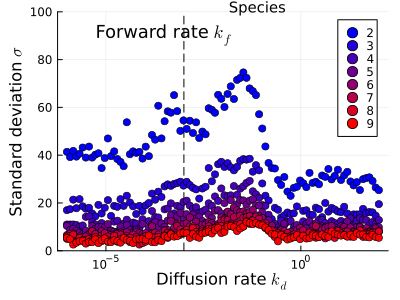

"./plots"

In [7]:
using LaTeXStrings

# p = plot()
title = "SD of monomers across diffusion rates \n (lattice, 2-way diffusion, t=500)"
s = scatter(size=(400,300), legend=:topright, ylim=(0,100))

n = 100
vals = exp10.(LinRange(-6,2,n))

# kf = 0.001
vline!([0.001], label=:none, linestyle=:dash, color=:black)
annotate!(6e-6, 90, text("Forward rate " * L"k_f", :left, 12, color=:black))

annotate!(1.5e-2, 102, text("Species", :left, 10, color=:black))

linear_blue_to_red = cgrad([:blue, :red], scale=:linear)

for i in 2:9
    # plot!(p, vals, stds[:, i], xscale=:log10, xlabel="kd", ylabel="STD(M)", legend= :none)
    scatter!(s, vals, stds[:, i], xscale=:log10, xlabel = "Diffusion rate " * L"k_d", ylabel="Standard deviation " * L"\sigma", label=i,
    marker_z=i, color=linear_blue_to_red, colorbar=false,)
end

# display(p)
display(s)

mkpath("./plots")
# savefig("./plots/sd-vs-kd.pdf")

In [ ]:
display(stds)

In [ ]:
std([1000,10,20,50,1,0,0,0,0])

In [8]:
mu = zeros(Float64, nsims, nspecies)

for i in 1:100
    for j in 1:nspecies
        mu[i, j] = mean(pops[i, :, j])
        # stds = dropdims(stds, dims=2)
    end
end

display(mu)

100×10 Matrix{Float64}:
  40.08    8.28   3.4    2.2    2.08   1.32   1.0    1.2    1.08   0.68
  40.0     7.84   3.48   2.2    1.72   1.36   1.44   1.24   0.96   0.6
  40.0     8.36   4.28   2.2    1.84   1.44   1.24   1.36   0.52   0.72
  40.16    7.88   3.56   2.16   1.68   0.92   1.08   0.76   0.68   0.56
  40.04    8.12   4.32   2.0    1.52   1.2    1.08   1.08   0.8    1.12
  40.08    8.64   3.72   2.12   1.4    1.04   1.12   0.88   0.84   0.64
  40.0     7.8    3.52   2.84   1.68   0.76   1.2    0.92   0.6    0.6
  40.16    8.72   3.6    2.88   1.4    1.36   0.96   1.0    0.72   0.64
  45.2     7.8    3.12   2.4    2.08   1.08   1.64   0.92   0.72   0.56
  40.08    8.04   2.88   2.2    1.84   1.16   1.4    1.16   0.96   0.68
   ⋮                                   ⋮                          
 387.88   99.68  64.64  44.44  36.72  33.2   28.0   24.8   21.56  20.48
 403.04  105.16  62.32  45.28  36.68  32.6   27.16  22.68  21.56  19.16
 417.8   105.6   64.04  47.0   38.4   32.08  26

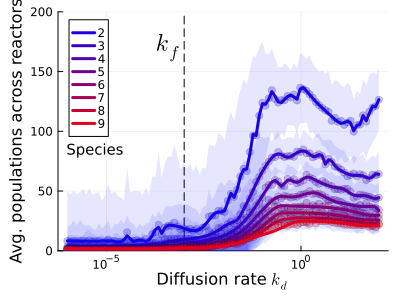

"/Users/alexandre/Documents/academic/3-research/projects/2023 spatial-topology/flow-complexity/milestones/04_mu(m)-vs-kd/A_adjust-range-kd/plots/mu-vs-kd.pdf"

In [9]:
using LaTeXStrings, Dierckx, Polynomials, Interpolations

gr()

# p = plot()
title = "Mean of monomers across diffusion rates \n (lattice, 2-way diffusion, t=500)"
s = scatter(size=(400,300), legend=:topleft, ylim=(0,200))

n = 100
vals = exp10.(LinRange(-6,2,n))

# kf = 0.001
vline!([0.001], label=:none, linestyle=:dash, color=:black)
annotate!(2e-4, 170, text(L"k_f", :left, 16, color=:black))

annotate!(1e-6, 85, text("Species", :left, 10, color=:black))

linear_blue_to_red = cgrad([:blue, :red], scale=:linear)

for i in 2:9
    # plot!(p, vals, stds[:, i], xscale=:log10, xlabel="kd", ylabel="STD(M)", legend= :none)
    scatter!(s, vals, mu[:, i], xscale=:log10, xlabel = "Diffusion rate " * L"k_d", ylabel="Avg. populations across reactors", label=:none,
    marker_z=i, color=linear_blue_to_red, colorbar=false, alpha=0.25)

    upper_bound = mu[:, i] .+ stds[:,i]
    lower_bound = mu[:, i] .- stds[:,i]
    # linealpha à cause de l’esti de bug y save pas le pdf avec lw=0
    plot!(s, vals, upper_bound, fillrange=lower_bound, linealpha=0, fillalpha=0.1, color=linear_blue_to_red, label=:none, linewidth=0)

    x = vals
    y = mu[:, i]

    # function moving_average(data, window_size)
    #     return [mean(data[i:i+window_size-1]) for i in 1:length(data)-window_size+1]
    # end
    # window_size = 10
    # ma = moving_average(y, window_size)
    # # spline = Spline1D(x, y, k=3)  # k=3 for cubic spline
    xfine = exp10.(LinRange(-6,2,100))
    # # yfine = spline.(xfine)

    # p = fit(x, y, 10)

    # Define the smoothing parameter (0 for interpolation, higher for more smoothing)
    smoothing_param = 150.0

    # Fit a smoothed spline to the data
    spl = Spline1D(x, y, s=smoothing_param)
    
    plot!(s, xfine, spl.(xfine), linewidth=3, color=linear_blue_to_red[(i-1)/9], label=i)
end

# display(p)
display(s)

mkpath("./plots")
savefig(s, "./plots/mu-vs-kd.pdf")

In [212]:
Pkg.add("Polynomials")

   Resolving package versions...
    Updating `~/Documents/academic/3-research/projects/2023 spatial-topology/flow-complexity/Project.toml`
  [f27b6e38] + Polynomials v4.0.11
  No Changes to `~/Documents/academic/3-research/projects/2023 spatial-topology/flow-complexity/Manifest.toml`
